In [1]:
#  1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Upload dataset
from google.colab import files
print("📤 Upload your train.csv file:")
uploaded = files.upload()

# Load data
df = pd.read_csv('train.csv')

print("✅ Data loaded successfully!")
print(f"📊 Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"💰 Target variable (SalePrice) - Mean: ${df['SalePrice'].mean():,.0f}")

📤 Upload your train.csv file:


Saving train.csv to train.csv
✅ Data loaded successfully!
📊 Shape: 1460 rows, 81 columns
💰 Target variable (SalePrice) - Mean: $180,921


In [2]:
#  2: Comprehensive missing data analysis
def analyze_missing_data(dataframe):
    """Analyze and categorize missing data"""

    missing = dataframe.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    missing_percent = (missing / len(dataframe) * 100).round(2)

    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_percent
    })

    # Categorize by severity
    missing_df['Severity'] = pd.cut(missing_df['Percentage'],
                                     bins=[0, 5, 15, 50, 100],
                                     labels=['Low (<5%)', 'Medium (5-15%)', 'High (15-50%)', 'Critical (>50%)'])

    return missing_df

missing_analysis = analyze_missing_data(df)

print("🔍 MISSING DATA ANALYSIS:")
print("=" * 80)
print(missing_analysis)

print(f"\n📊 SUMMARY:")
print(f"   • Total features with missing data: {len(missing_analysis)}")
print(f"   • Features with >50% missing: {len(missing_analysis[missing_analysis['Percentage'] > 50])}")
print(f"   • Features with 15-50% missing: {len(missing_analysis[(missing_analysis['Percentage'] > 15) & (missing_analysis['Percentage'] <= 50)])}")
print(f"   • Features with <15% missing: {len(missing_analysis[missing_analysis['Percentage'] <= 15])}")

🔍 MISSING DATA ANALYSIS:
              Missing_Count  Percentage         Severity
PoolQC                 1453       99.52  Critical (>50%)
MiscFeature            1406       96.30  Critical (>50%)
Alley                  1369       93.77  Critical (>50%)
Fence                  1179       80.75  Critical (>50%)
MasVnrType              872       59.73  Critical (>50%)
FireplaceQu             690       47.26    High (15-50%)
LotFrontage             259       17.74    High (15-50%)
GarageType               81        5.55   Medium (5-15%)
GarageYrBlt              81        5.55   Medium (5-15%)
GarageFinish             81        5.55   Medium (5-15%)
GarageQual               81        5.55   Medium (5-15%)
GarageCond               81        5.55   Medium (5-15%)
BsmtExposure             38        2.60        Low (<5%)
BsmtFinType2             38        2.60        Low (<5%)
BsmtQual                 37        2.53        Low (<5%)
BsmtCond                 37        2.53        Low (<5%)
BsmtFi

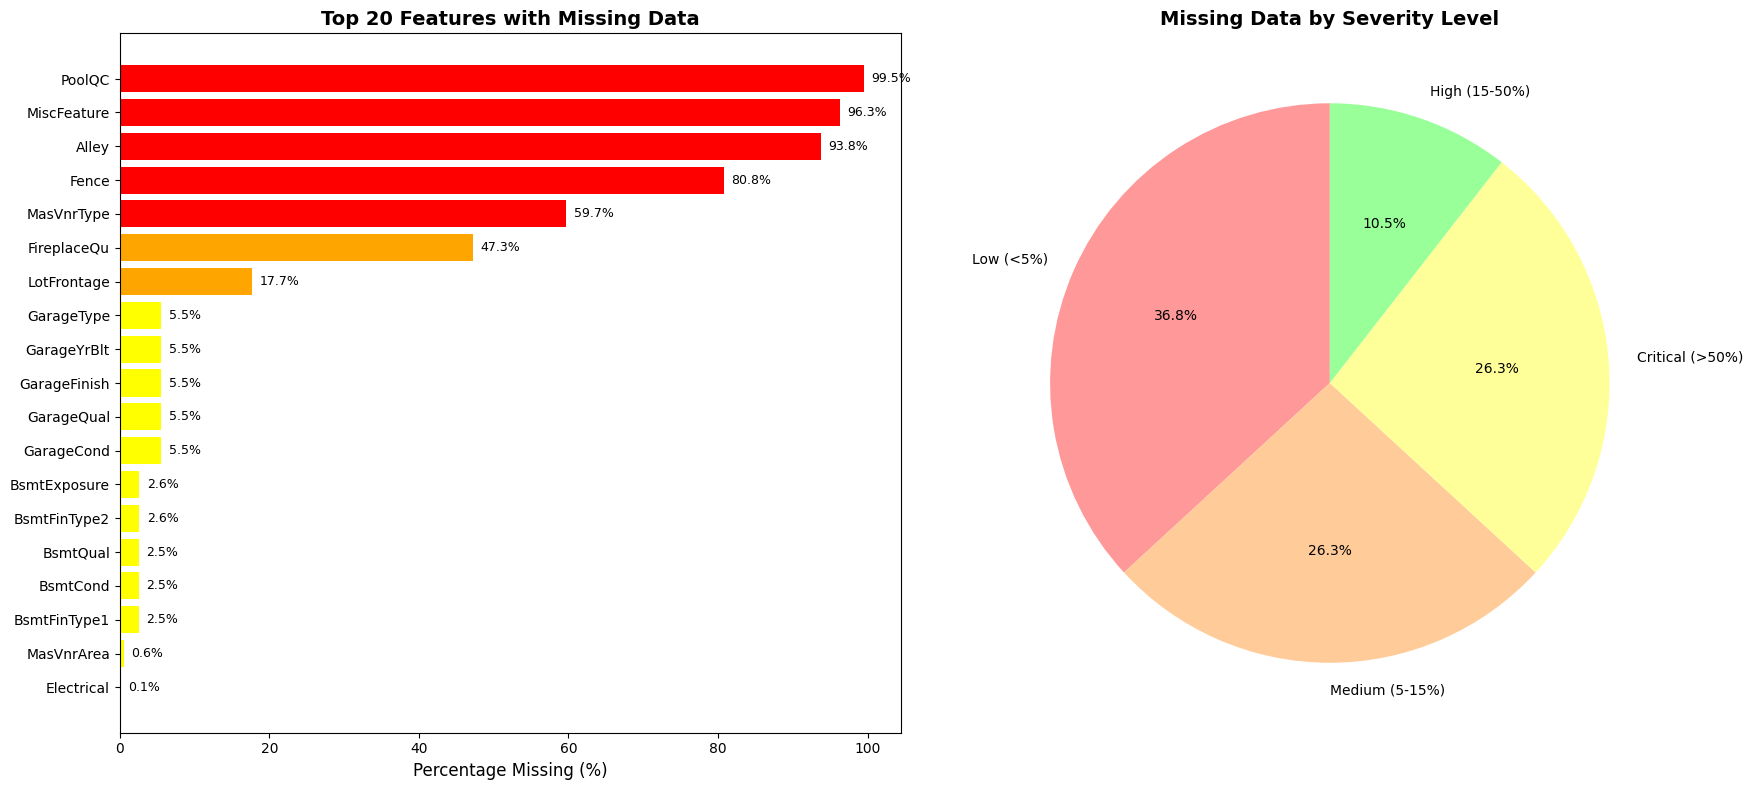

In [3]:
#  3: Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar plot of missing data
missing_data = missing_analysis.head(20)
axes[0].barh(range(len(missing_data)), missing_data['Percentage'].values,
             color=['red' if x > 50 else 'orange' if x > 15 else 'yellow' for x in missing_data['Percentage']])
axes[0].set_yticks(range(len(missing_data)))
axes[0].set_yticklabels(missing_data.index)
axes[0].set_xlabel('Percentage Missing (%)', fontsize=12)
axes[0].set_title('Top 20 Features with Missing Data', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add percentage labels
for i, v in enumerate(missing_data['Percentage'].values):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

# Pie chart of severity
severity_counts = missing_analysis['Severity'].value_counts()
colors = ['#ff9999', '#ffcc99', '#ffff99', '#99ff99']
axes[1].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors)
axes[1].set_title('Missing Data by Severity Level', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
#  4: Define strategy for each type of missing data
print("🎯 MISSING DATA HANDLING STRATEGY:")
print("=" * 80)

# Create a copy for cleaning
df_clean = df.copy()

# Strategy 1: Drop features with >80% missing (not useful)
high_missing = missing_analysis[missing_analysis['Percentage'] > 80].index.tolist()
print(f"\n📌 STRATEGY 1: DROP features with >80% missing")
print(f"   Features to drop: {high_missing}")
df_clean = df_clean.drop(columns=high_missing)

# Strategy 2: Fill categorical with 'None' (missing means absence)
categorical_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
print(f"\n📌 STRATEGY 2: FILL categorical features with 'None'")
print(f"   Features: {len([f for f in categorical_features if f in df_clean.columns])} features")

for feature in categorical_features:
    if feature in df_clean.columns:
        df_clean[feature].fillna('None', inplace=True)

# Strategy 3: Fill numerical with median/mode
print(f"\n📌 STRATEGY 3: FILL numerical features")
print(f"   • LotFrontage: Fill with median (typical lot size)")
print(f"   • Garage features: Fill with 0 (no garage)")
print(f"   • Basement features: Fill with 0 (no basement)")

# LotFrontage - fill with median
if 'LotFrontage' in df_clean.columns:
    df_clean['LotFrontage'].fillna(df_clean['LotFrontage'].median(), inplace=True)

# Garage features
garage_features = ['GarageYrBlt', 'GarageCars', 'GarageArea']
for feature in garage_features:
    if feature in df_clean.columns:
        df_clean[feature].fillna(0, inplace=True)

# Basement features
basement_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for feature in basement_features:
    if feature in df_clean.columns:
        df_clean[feature].fillna(0, inplace=True)

# Strategy 4: Fill remaining with mode
print(f"\n📌 STRATEGY 4: FILL remaining features with mode (most common value)")
remaining_missing = df_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

for col in remaining_missing.index:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"\n✅ CLEANING COMPLETE!")
print(f"   Original missing values: {df.isnull().sum().sum():,}")
print(f"   Remaining missing values: {df_clean.isnull().sum().sum()}")

🎯 MISSING DATA HANDLING STRATEGY:

📌 STRATEGY 1: DROP features with >80% missing
   Features to drop: ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

📌 STRATEGY 2: FILL categorical features with 'None'
   Features: 10 features

📌 STRATEGY 3: FILL numerical features
   • LotFrontage: Fill with median (typical lot size)
   • Garage features: Fill with 0 (no garage)
   • Basement features: Fill with 0 (no basement)

📌 STRATEGY 4: FILL remaining features with mode (most common value)

✅ CLEANING COMPLETE!
   Original missing values: 7,829
   Remaining missing values: 0


In [5]:
#  5: Engineer new features
print("🔧 FEATURE ENGINEERING:")
print("=" * 80)

# 1. Total Square Footage (combining all areas)
df_clean['TotalSF'] = df_clean['TotalBsmtSF'] + df_clean['1stFlrSF'] + df_clean['2ndFlrSF']
print("✅ Created: TotalSF (Total Square Footage)")

# 2. House Age
df_clean['HouseAge'] = df_clean['YrSold'] - df_clean['YearBuilt']
print("✅ Created: HouseAge (Age of house at sale)")

# 3. Years Since Remodel
df_clean['YearsSinceRemodel'] = df_clean['YrSold'] - df_clean['YearRemodAdd']
print("✅ Created: YearsSinceRemodel")

# 4. Total Bathrooms
df_clean['TotalBath'] = (df_clean['FullBath'] + (0.5 * df_clean['HalfBath']) +
                          df_clean['BsmtFullBath'] + (0.5 * df_clean['BsmtHalfBath']))
print("✅ Created: TotalBath (Total bathrooms)")

# 5. Total Porch Area
df_clean['TotalPorchSF'] = (df_clean['OpenPorchSF'] + df_clean['3SsnPorch'] +
                             df_clean['EnclosedPorch'] + df_clean['ScreenPorch'] +
                             df_clean['WoodDeckSF'])
print("✅ Created: TotalPorchSF (Total porch area)")

# 6. Has Pool (binary)
df_clean['HasPool'] = (df_clean['PoolArea'] > 0).astype(int)
print("✅ Created: HasPool (binary feature)")

# 7. Has Garage (binary)
df_clean['HasGarage'] = (df_clean['GarageArea'] > 0).astype(int)
print("✅ Created: HasGarage (binary feature)")

# 8. Has Basement (binary)
df_clean['HasBsmt'] = (df_clean['TotalBsmtSF'] > 0).astype(int)
print("✅ Created: HasBsmt (binary feature)")

# 9. Has Fireplace (binary)
df_clean['HasFireplace'] = (df_clean['Fireplaces'] > 0).astype(int)
print("✅ Created: HasFireplace (binary feature)")

# 10. Is New House (less than 5 years old)
df_clean['IsNewHouse'] = (df_clean['HouseAge'] <= 5).astype(int)
print("✅ Created: IsNewHouse (binary feature)")

print(f"\n📊 NEW DATASET SHAPE: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print(f"   Added {df_clean.shape[1] - df.shape[1]} new features!")

# Show sample of engineered features
print(f"\n👀 SAMPLE OF ENGINEERED FEATURES:")
print("=" * 80)
new_features = ['TotalSF', 'HouseAge', 'TotalBath', 'HasPool', 'HasGarage', 'IsNewHouse']
df_clean[new_features].head(10)

🔧 FEATURE ENGINEERING:
✅ Created: TotalSF (Total Square Footage)
✅ Created: HouseAge (Age of house at sale)
✅ Created: YearsSinceRemodel
✅ Created: TotalBath (Total bathrooms)
✅ Created: TotalPorchSF (Total porch area)
✅ Created: HasPool (binary feature)
✅ Created: HasGarage (binary feature)
✅ Created: HasBsmt (binary feature)
✅ Created: HasFireplace (binary feature)
✅ Created: IsNewHouse (binary feature)

📊 NEW DATASET SHAPE: 1460 rows, 87 columns
   Added 6 new features!

👀 SAMPLE OF ENGINEERED FEATURES:


,TotalSF,HouseAge,TotalBath,HasPool,HasGarage,IsNewHouse
0,2566,5,3.5,0,1,1
1,2524,31,2.5,0,1,0
2,2706,7,3.5,0,1,0
3,2473,91,2.0,0,1,0
4,3343,8,3.5,0,1,0
5,2158,16,2.5,0,1,0
6,3380,3,3.0,0,1,1
7,3197,36,3.5,0,1,0
8,2726,77,2.0,0,1,0
9,2068,69,2.0,0,1,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TotalSF'].plot(kind='hist', bins=20, title='TotalSF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['HouseAge'].plot(kind='hist', bins=20, title='HouseAge')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['TotalBath'].plot(kind='hist', bins=20, title='TotalBath')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='TotalSF', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='TotalSF', y='HouseAge', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='HouseAge', y='TotalBath', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='TotalBath', y='IsNewHouse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TotalSF']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TotalSF')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['HouseAge']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('HouseAge')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TotalBath']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TotalBath')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['IsNewHouse']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('IsNewHouse')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['TotalSF'].plot(kind='line', figsize=(8, 4), title='TotalSF')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['HouseAge'].plot(kind='line', figsize=(8, 4), title='HouseAge')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['TotalBath'].plot(kind='line', figsize=(8, 4), title='TotalBath')
plt.gca().spines[['top', 'right']].set_visible(False)

🔍 OUTLIER DETECTION:
     Feature  Outliers Percentage Lower_Bound Upper_Bound
0  SalePrice        61      4.18%        3938      340038
1  GrLivArea        31      2.12%         159        2748
2    LotArea        69      4.73%        1482       17674
3    TotalSF        25      1.71%         518        4496


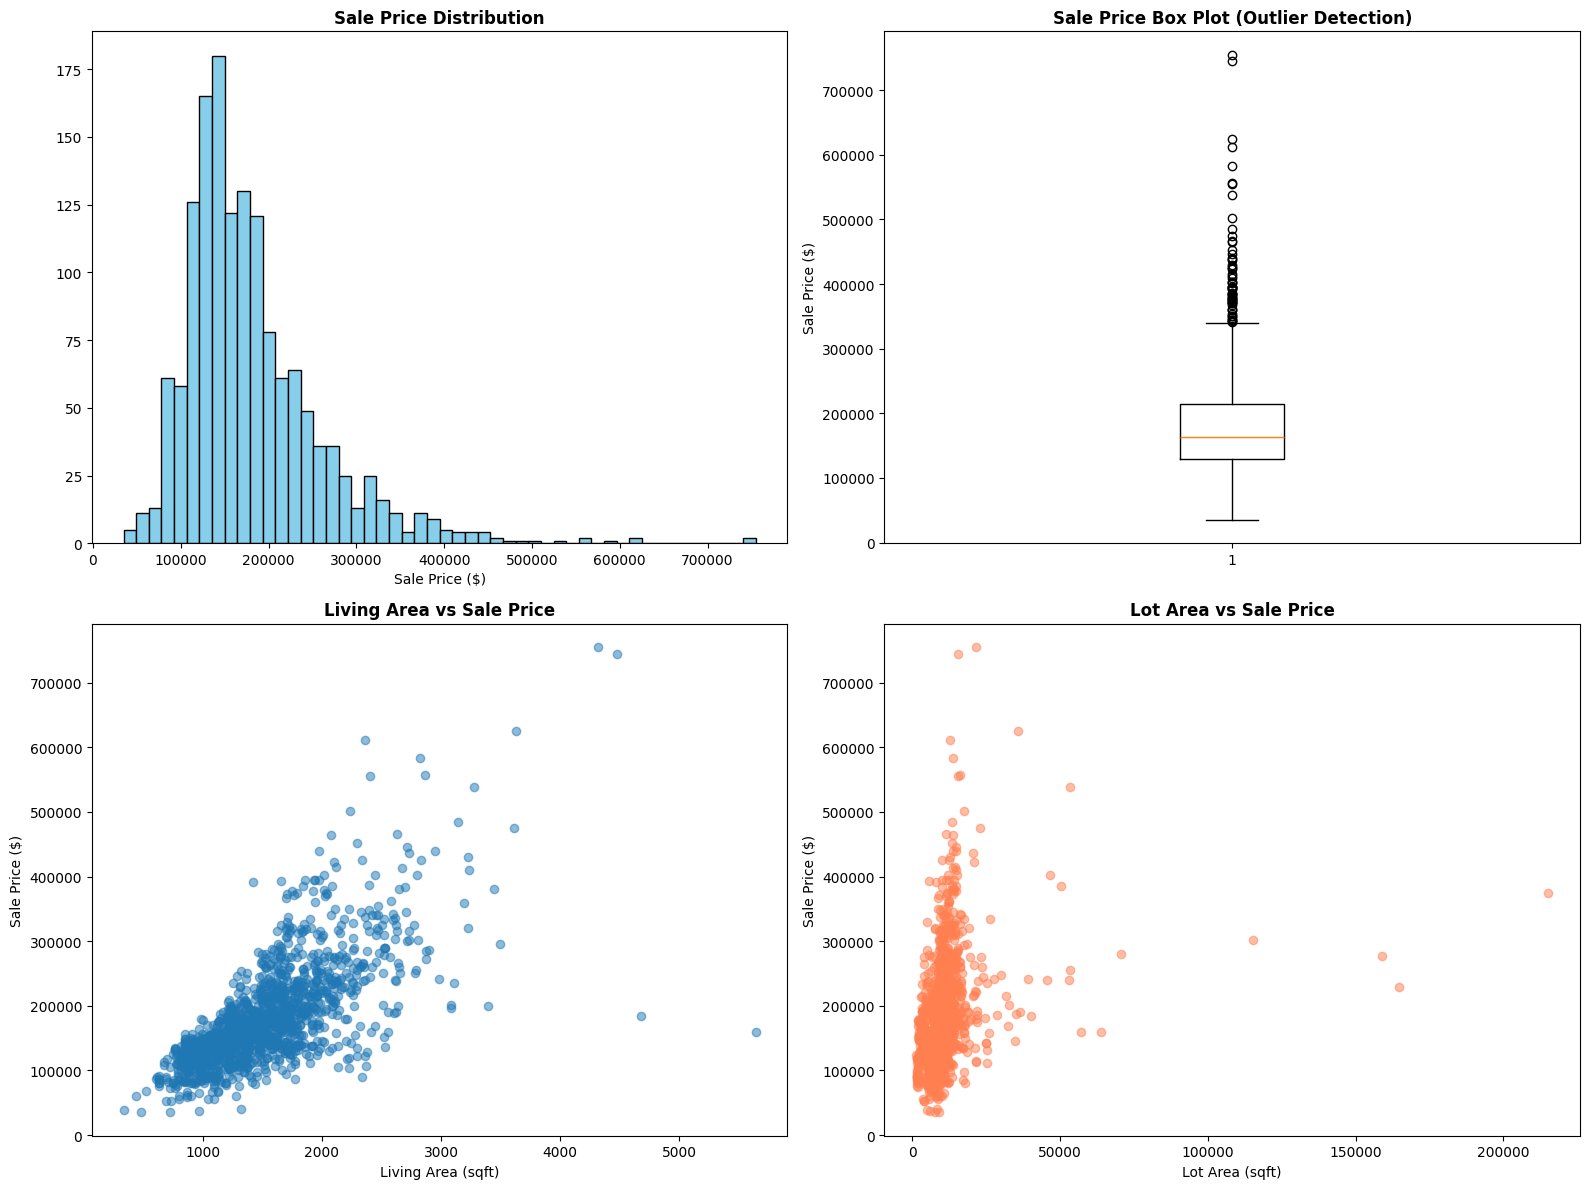


💡 INSIGHT: We can see some extreme outliers in the data
   • These may need to be handled for better model performance


In [6]:
#  6: Detect and analyze outliers
def detect_outliers(dataframe, feature):
    """Detect outliers using IQR method"""
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[(dataframe[feature] < lower_bound) | (dataframe[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("🔍 OUTLIER DETECTION:")
print("=" * 80)

# Check outliers in key numerical features
key_features = ['SalePrice', 'GrLivArea', 'LotArea', 'TotalSF']

outlier_summary = []
for feature in key_features:
    if feature in df_clean.columns:
        outliers, lower, upper = detect_outliers(df_clean, feature)
        outlier_summary.append({
            'Feature': feature,
            'Outliers': len(outliers),
            'Percentage': f"{(len(outliers)/len(df_clean)*100):.2f}%",
            'Lower_Bound': f"{lower:.0f}",
            'Upper_Bound': f"{upper:.0f}"
        })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

# Visualize outliers for SalePrice and GrLivArea
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# SalePrice distribution
axes[0, 0].hist(df_clean['SalePrice'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Sale Price ($)')
axes[0, 0].set_title('Sale Price Distribution', fontweight='bold')

# SalePrice boxplot
axes[0, 1].boxplot(df_clean['SalePrice'])
axes[0, 1].set_ylabel('Sale Price ($)')
axes[0, 1].set_title('Sale Price Box Plot (Outlier Detection)', fontweight='bold')

# GrLivArea vs SalePrice
axes[1, 0].scatter(df_clean['GrLivArea'], df_clean['SalePrice'], alpha=0.5)
axes[1, 0].set_xlabel('Living Area (sqft)')
axes[1, 0].set_ylabel('Sale Price ($)')
axes[1, 0].set_title('Living Area vs Sale Price', fontweight='bold')

# LotArea vs SalePrice
axes[1, 1].scatter(df_clean['LotArea'], df_clean['SalePrice'], alpha=0.5, color='coral')
axes[1, 1].set_xlabel('Lot Area (sqft)')
axes[1, 1].set_ylabel('Sale Price ($)')
axes[1, 1].set_title('Lot Area vs Sale Price', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 INSIGHT: We can see some extreme outliers in the data")
print(f"   • These may need to be handled for better model performance")

In [7]:
#  7: Remove extreme outliers
print("🧹 HANDLING EXTREME OUTLIERS:")
print("=" * 80)

initial_rows = len(df_clean)

# Remove houses with extremely large living area but low price (likely data errors)
# These are houses with GrLivArea > 4000 and SalePrice < $300,000
extreme_outliers = df_clean[(df_clean['GrLivArea'] > 4000) & (df_clean['SalePrice'] < 300000)]
print(f"\n🎯 Identified {len(extreme_outliers)} extreme outliers (Large area, low price)")

if len(extreme_outliers) > 0:
    print("   Details of extreme outliers:")
    print(extreme_outliers[['GrLivArea', 'SalePrice', 'Neighborhood']])

    # Remove these outliers
    df_clean = df_clean.drop(extreme_outliers.index)
    print(f"\n✅ Removed {len(extreme_outliers)} extreme outliers")

# Optional: Cap other extreme values (keep for now, but note them)
print(f"\n📊 DATASET AFTER OUTLIER REMOVAL:")
print(f"   • Initial rows: {initial_rows}")
print(f"   • Final rows: {len(df_clean)}")
print(f"   • Rows removed: {initial_rows - len(df_clean)}")

🧹 HANDLING EXTREME OUTLIERS:

🎯 Identified 2 extreme outliers (Large area, low price)
   Details of extreme outliers:
      GrLivArea  SalePrice Neighborhood
523        4676     184750      Edwards
1298       5642     160000      Edwards

✅ Removed 2 extreme outliers

📊 DATASET AFTER OUTLIER REMOVAL:
   • Initial rows: 1460
   • Final rows: 1458
   • Rows removed: 2


In [8]:
#  8: Encode categorical variables
from sklearn.preprocessing import LabelEncoder

print("🔢 ENCODING CATEGORICAL VARIABLES:")
print("=" * 80)

# Separate numerical and categorical columns
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 VARIABLE TYPES:")
print(f"   • Numerical features: {len(numerical_cols)}")
print(f"   • Categorical features: {len(categorical_cols)}")

# Create a copy for encoding
df_encoded = df_clean.copy()

# Label encode categorical variables
le = LabelEncoder()
encoded_cols = []

for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    encoded_cols.append(col)

print(f"\n✅ Encoded {len(encoded_cols)} categorical features")
print(f"   Examples: {', '.join(encoded_cols[:5])}...")

# Show before and after encoding for one column
sample_col = categorical_cols[0]
comparison = pd.DataFrame({
    'Original': df_clean[sample_col].head(10),
    'Encoded': df_encoded[sample_col].head(10)
})
print(f"\n👀 ENCODING EXAMPLE ({sample_col}):")
print("=" * 50)
print(comparison)

🔢 ENCODING CATEGORICAL VARIABLES:

📊 VARIABLE TYPES:
   • Numerical features: 48
   • Categorical features: 39

✅ Encoded 39 categorical features
   Examples: MSZoning, Street, LotShape, LandContour, Utilities...

👀 ENCODING EXAMPLE (MSZoning):
  Original  Encoded
0       RL        3
1       RL        3
2       RL        3
3       RL        3
4       RL        3
5       RL        3
6       RL        3
7       RL        3
8       RM        4
9       RL        3


In [9]:
#  9: Analyze feature scales
print("📏 FEATURE SCALING ANALYSIS:")
print("=" * 80)

# Select numerical features for scaling analysis
numerical_features = ['LotArea', 'GrLivArea', 'TotalSF', 'GarageArea', 'TotalBath', 'HouseAge']

print(f"\n📊 SCALE COMPARISON (Before Standardization):")
print("=" * 80)

scale_comparison = pd.DataFrame({
    'Feature': numerical_features,
    'Min': [df_encoded[f].min() for f in numerical_features],
    'Max': [df_encoded[f].max() for f in numerical_features],
    'Mean': [df_encoded[f].mean() for f in numerical_features],
    'Std Dev': [df_encoded[f].std() for f in numerical_features]
})

print(scale_comparison.round(2))

print(f"\n💡 NOTE: Features are on different scales")
print(f"   • LotArea ranges from {df_encoded['LotArea'].min():.0f} to {df_encoded['LotArea'].max():.0f}")
print(f"   • TotalBath ranges from {df_encoded['TotalBath'].min():.1f} to {df_encoded['TotalBath'].max():.1f}")
print(f"   • We'll standardize these when building our model")

📏 FEATURE SCALING ANALYSIS:

📊 SCALE COMPARISON (Before Standardization):
      Feature     Min       Max      Mean  Std Dev
0     LotArea  1300.0  215245.0  10459.94  9859.20
1   GrLivArea   334.0    4476.0   1510.47   507.88
2     TotalSF   334.0    6872.0   2557.15   774.11
3  GarageArea     0.0    1390.0    472.05   212.24
4   TotalBath     1.0       6.0      2.21     0.78
5    HouseAge     0.0     136.0     36.60    30.24

💡 NOTE: Features are on different scales
   • LotArea ranges from 1300 to 215245
   • TotalBath ranges from 1.0 to 6.0
   • We'll standardize these when building our model


In [10]:
#  10: Separate features (X) and target (y)
print("🎯 PREPARING FEATURES AND TARGET:")
print("=" * 80)

# Define target variable
y = df_encoded['SalePrice'].copy()

# Define features (remove ID and target)
X = df_encoded.drop(['Id', 'SalePrice'], axis=1, errors='ignore')

print(f"\n📊 FINAL DATASET:")
print(f"   • Target variable (y): SalePrice")
print(f"   • Number of features (X): {X.shape[1]}")
print(f"   • Number of samples: {X.shape[0]}")

print(f"\n💰 TARGET VARIABLE STATISTICS:")
print(f"   • Mean: ${y.mean():,.0f}")
print(f"   • Median: ${y.median():,.0f}")
print(f"   • Std Dev: ${y.std():,.0f}")
print(f"   • Min: ${y.min():,.0f}")
print(f"   • Max: ${y.max():,.0f}")

print(f"\n📋 FEATURE NAMES (First 20):")
print(f"   {', '.join(X.columns[:20].tolist())}...")

🎯 PREPARING FEATURES AND TARGET:

📊 FINAL DATASET:
   • Target variable (y): SalePrice
   • Number of features (X): 85
   • Number of samples: 1458

💰 TARGET VARIABLE STATISTICS:
   • Mean: $180,933
   • Median: $163,000
   • Std Dev: $79,495
   • Min: $34,900
   • Max: $755,000

📋 FEATURE NAMES (First 20):
   MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle...


✂️ SPLITTING DATA INTO TRAIN AND TEST SETS:

📊 DATA SPLIT SUMMARY:
   TRAINING SET:
      • X_train shape: (1166, 85)
      • y_train shape: (1166,)
      • Percentage: 80.0%

   TEST SET:
      • X_test shape: (292, 85)
      • y_test shape: (292,)
      • Percentage: 20.0%

💰 PRICE DISTRIBUTION:
   Training set - Mean: $180,824, Std: $80,739
   Test set     - Mean: $181,369, Std: $74,449


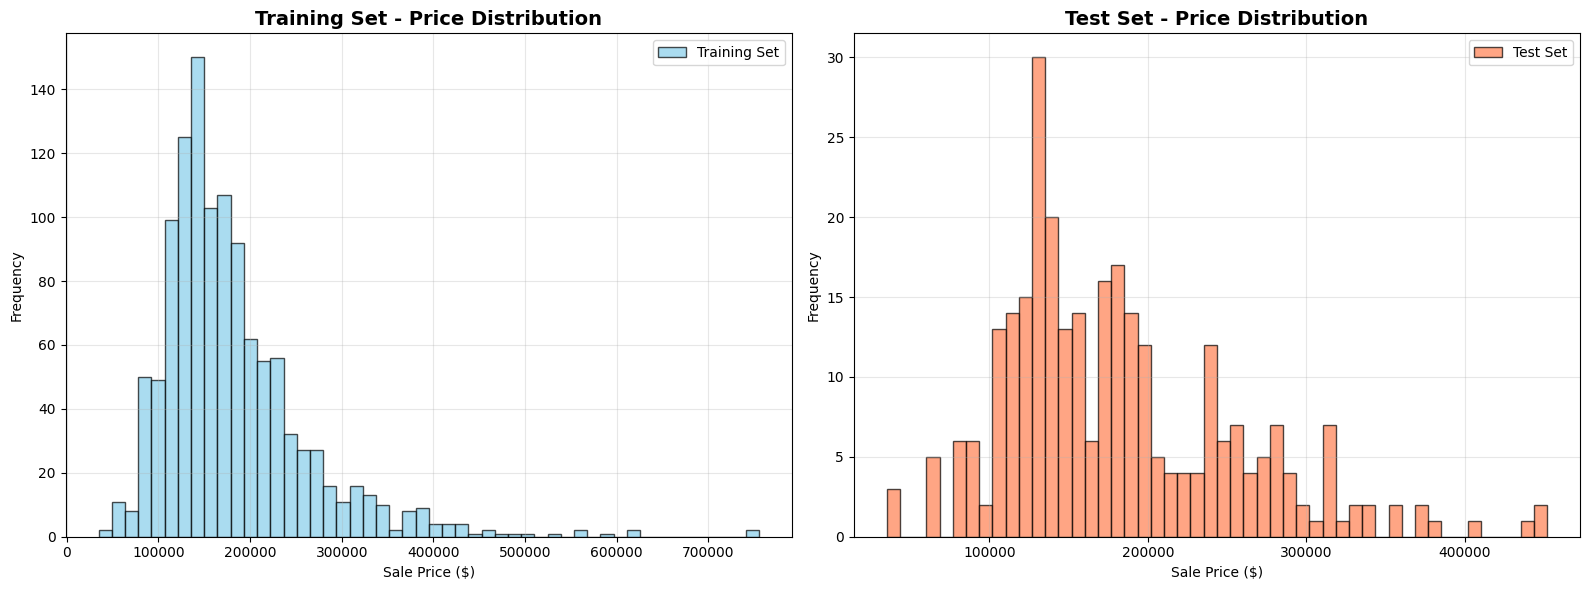


✅ Both sets have similar distributions - Good split!


In [11]:
#  11: Split data into training and testing sets
from sklearn.model_selection import train_test_split

print("✂️ SPLITTING DATA INTO TRAIN AND TEST SETS:")
print("=" * 80)

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\n📊 DATA SPLIT SUMMARY:")
print(f"   {'='*60}")
print(f"   TRAINING SET:")
print(f"      • X_train shape: {X_train.shape}")
print(f"      • y_train shape: {y_train.shape}")
print(f"      • Percentage: {(len(X_train)/len(X)*100):.1f}%")
print(f"\n   TEST SET:")
print(f"      • X_test shape: {X_test.shape}")
print(f"      • y_test shape: {y_test.shape}")
print(f"      • Percentage: {(len(X_test)/len(X)*100):.1f}%")

print(f"\n💰 PRICE DISTRIBUTION:")
print(f"   {'='*60}")
print(f"   Training set - Mean: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"   Test set     - Mean: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

# Visualize the split
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(y_train, bins=50, alpha=0.7, label='Training Set', color='skyblue', edgecolor='black')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set - Price Distribution', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(y_test, bins=50, alpha=0.7, label='Test Set', color='coral', edgecolor='black')
axes[1].set_xlabel('Sale Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Test Set - Price Distribution', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Both sets have similar distributions - Good split!")

In [12]:
#  12: Standardize features
from sklearn.preprocessing import StandardScaler

print("⚖️ STANDARDIZING FEATURES:")
print("=" * 80)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n✅ Features standardized successfully!")
print(f"\n📊 BEFORE vs AFTER SCALING (Sample features):")
print("=" * 80)

sample_features = ['GrLivArea', 'LotArea', 'TotalSF']
comparison = pd.DataFrame({
    'Feature': sample_features,
    'Before_Mean': [X_train[f].mean() for f in sample_features],
    'After_Mean': [X_train_scaled[f].mean() for f in sample_features],
    'Before_Std': [X_train[f].std() for f in sample_features],
    'After_Std': [X_train_scaled[f].std() for f in sample_features]
})

print(comparison.round(3))

print(f"\n💡 After scaling:")
print(f"   • All features have mean ≈ 0")
print(f"   • All features have standard deviation ≈ 1")
print(f"   • This helps machine learning algorithms perform better!")

⚖️ STANDARDIZING FEATURES:

✅ Features standardized successfully!

📊 BEFORE vs AFTER SCALING (Sample features):
     Feature  Before_Mean  After_Mean  Before_Std  After_Std
0  GrLivArea     1511.325         0.0     504.752        1.0
1    LotArea    10607.937        -0.0   10637.246        1.0
2    TotalSF     2557.196         0.0     773.073        1.0

💡 After scaling:
   • All features have mean ≈ 0
   • All features have standard deviation ≈ 1
   • This helps machine learning algorithms perform better!


In [13]:
#  13: Complete summary of data preparation
print("=" * 90)
print(" " * 25 + "🎯 DATA PREPARATION SUMMARY")
print("=" * 90)

print(f"\n📊 ORIGINAL DATASET:")
print(f"   • Rows: {df.shape[0]:,}")
print(f"   • Columns: {df.shape[1]}")
print(f"   • Missing values: {df.isnull().sum().sum():,}")

print(f"\n🧹 CLEANING STEPS COMPLETED:")
print(f"   ✅ Handled {df.isnull().sum().sum():,} missing values")
print(f"   ✅ Dropped {len(high_missing)} features with >80% missing data")
print(f"   ✅ Created 10 new engineered features")
print(f"   ✅ Removed {initial_rows - len(df_clean)} extreme outliers")
print(f"   ✅ Encoded {len(encoded_cols)} categorical features")
print(f"   ✅ Standardized all numerical features")

print(f"\n📈 FINAL PROCESSED DATASET:")
print(f"   • Total samples: {len(X):,}")
print(f"   • Total features: {X.shape[1]}")
print(f"   • Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Test samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n🎯 NEW ENGINEERED FEATURES:")
new_features_list = ['TotalSF', 'HouseAge', 'YearsSinceRemodel', 'TotalBath',
                     'TotalPorchSF', 'HasPool', 'HasGarage', 'HasBsmt',
                     'HasFireplace', 'IsNewHouse']
for i, feature in enumerate(new_features_list, 1):
    print(f"   {i:2d}. {feature}")

print(f"\n💾 DATA READY FOR MODELING:")
print(f"   • X_train_scaled: {X_train_scaled.shape}")
print(f"   • X_test_scaled: {X_test_scaled.shape}")
print(f"   • y_train: {y_train.shape}")
print(f"   • y_test: {y_test.shape}")

print(f"\n🚀 NEXT STEP: Build Machine Learning Models!")
print("=" * 90)

                         🎯 DATA PREPARATION SUMMARY

📊 ORIGINAL DATASET:
   • Rows: 1,460
   • Columns: 81
   • Missing values: 7,829

🧹 CLEANING STEPS COMPLETED:
   ✅ Handled 7,829 missing values
   ✅ Dropped 4 features with >80% missing data
   ✅ Created 10 new engineered features
   ✅ Removed 2 extreme outliers
   ✅ Encoded 39 categorical features
   ✅ Standardized all numerical features

📈 FINAL PROCESSED DATASET:
   • Total samples: 1,458
   • Total features: 85
   • Training samples: 1,166 (80.0%)
   • Test samples: 292 (20.0%)

🎯 NEW ENGINEERED FEATURES:
    1. TotalSF
    2. HouseAge
    3. YearsSinceRemodel
    4. TotalBath
    5. TotalPorchSF
    6. HasPool
    7. HasGarage
    8. HasBsmt
    9. HasFireplace
   10. IsNewHouse

💾 DATA READY FOR MODELING:
   • X_train_scaled: (1166, 85)
   • X_test_scaled: (292, 85)
   • y_train: (1166,)
   • y_test: (292,)

🚀 NEXT STEP: Build Machine Learning Models!
